# Dense Flipout Tests

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
      print('GPU device not found. Using CPU')
else:
      print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


# Model

(5000, 1)


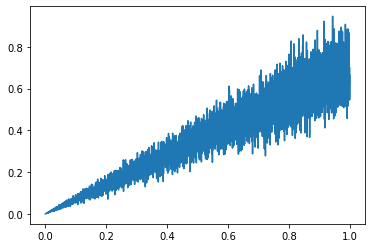

In [64]:
def create_training_data(size=5000):
    x_train = np.arange(0, 1, 1/size)
    y_train = [x * 0.7 + np.random.normal(0, x*0.1) for x in x_train]
    
    return (tf.expand_dims(x_train, 1), tf.expand_dims(y_train, 1))

x_train, y_train = create_training_data()
plt.plot(x_train[:, 0], y_train[:, 0])
print(x_train.shape)

In [78]:
# https://github.com/tensorflow/probability/issues/282

batch_size = 128

def kernel_divergence_fn(q, p, _):
    return tfd.kl_divergence(q, p) / tf.cast(x_train.shape[0], tf.float32)

def loss(y_true, y_pred):
    return tfk.losses.categorical_crossentropy(y_true, y_pred)

model = None
if True:
    model = tfk.Sequential([
        tfpl.DenseFlipout(32, input_shape=(1,), kernel_divergence_fn=kernel_divergence_fn),
        tfpl.DenseFlipout(32, kernel_divergence_fn=kernel_divergence_fn),
        tfpl.DenseFlipout(1, kernel_divergence_fn=kernel_divergence_fn)
    ])
    model.compile(optimizer=tfk.optimizers.Adam(0.0001), loss=loss)
else:
    model = tfk.Sequential([
        tfkl.Dense(32, input_shape=(1,)),
        tfkl.Dense(32),
        tfkl.Dense(1),
    ])
    #model.compile(optimizer=tfk.optimizers.Adam(0.01), loss=tfk.losses.mean_squared_error)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout_24 (DenseFlipo (None, 32)                96        
_________________________________________________________________
dense_flipout_25 (DenseFlipo (None, 32)                2080      
_________________________________________________________________
dense_flipout_26 (DenseFlipo (None, 1)                 65        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, validation_split=0.1, verbose=0)
print("Done")

Done


In [51]:
# without model compile

features = x_train
labels = y_train

optimizer = tfk.optimizers.Adam(0.0001)

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=logits)
        kl = sum(model.losses)
        loss = neg_log_likelihood + kl

    _grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(_grad, model.trainable_variables))

train_step(features, labels)
model.predict([0.2])

array([[-0.65936226]], dtype=float32)

0.3643942


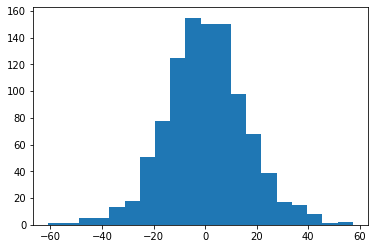

In [89]:
y_pred = []
for i in range(1000):
    y_pred += [np.squeeze(model.predict([0.5]))]

print(np.mean(y_pred))
plt.hist(y_pred, bins=20)
None

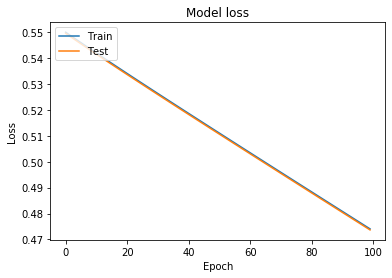

In [81]:
if hasattr(model, "history"):
    history = model.history

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()